In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638 (from 1)
Receiving objects: 100% (1638/1638), 75.94 MiB | 16.32 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (3045/3045), done.


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()]),
}

In [5]:
data_dir = 'observations/experiements/dest_folder'
image_datasets = {X: datasets.ImageFolder(os.path.join(data_dir, X), data_transforms[X]) for X in ['train', 'test']}
dataloaders = {X: torch.utils.data.DataLoader(image_datasets[X], batch_size=8, shuffle=True) for X in ['train', 'test']}

dataset_sizes = {X: len(image_datasets[X]) for X in ['train', 'test']}

class_names = image_datasets['train'].classes
print(class_names)

['with_mask', 'without_mask']


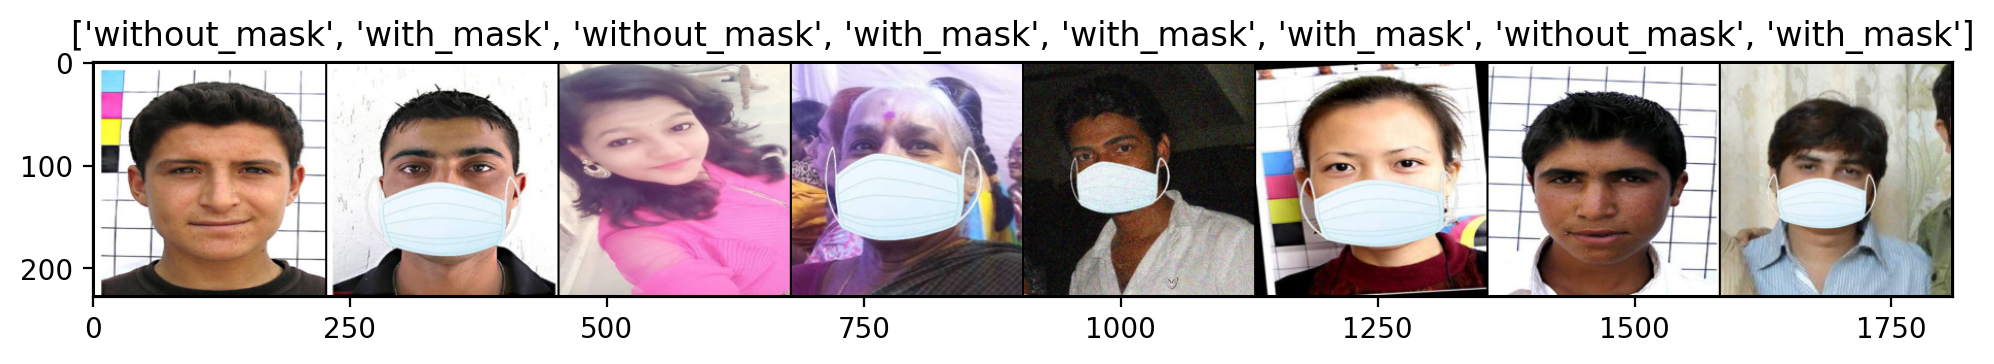

In [6]:
plt.figure(figsize=(12, 8))

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[X] for X in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:

model = models.resnet50(pretrained=True)

for param in model.parameters():
  param.requires_grad = False


num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2649 Acc: 0.8958
test Loss: 0.0647 Acc: 0.9845

Epoch 1/9
----------
train Loss: 0.1546 Acc: 0.9392
test Loss: 0.0406 Acc: 0.9948

Epoch 2/9
----------
train Loss: 0.1525 Acc: 0.9407
test Loss: 0.0342 Acc: 0.9897

Epoch 3/9
----------
train Loss: 0.1184 Acc: 0.9536
test Loss: 0.0250 Acc: 1.0000

Epoch 4/9
----------
train Loss: 0.0711 Acc: 0.9726
test Loss: 0.0206 Acc: 0.9948

Epoch 5/9
----------
train Loss: 0.1266 Acc: 0.9452
test Loss: 0.0216 Acc: 0.9948

Epoch 6/9
----------
train Loss: 0.0745 Acc: 0.9749
test Loss: 0.0519 Acc: 0.9897

Epoch 7/9
----------
train Loss: 0.0949 Acc: 0.9620
test Loss: 0.0221 Acc: 0.9948

Epoch 8/9
----------
train Loss: 0.0932 Acc: 0.9567
test Loss: 0.0239 Acc: 0.9948

Epoch 9/9
----------
train Loss: 0.0824 Acc: 0.9703
test Loss: 0.0246 Acc: 0.9948

Training complete in 63m 42s
Best val Acc: 1.000000


In [ ]:
torch.save(model,'/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/SprintFinal/face_mask_model.pth')

In [ ]:
caminho_modelo = '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/SprintFinal/face_mask_model.pth'

modelo = torch.load(caminho_modelo)

modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = range(1, 11)  # 10 épocas
train_loss = [0.2634, 0.1701, 0.1411, 0.1367, 0.0824, 0.1020, 0.0980, 0.0997, 0.0886, 0.0664]
train_acc = [0.8958, 0.9300, 0.9468, 0.9445, 0.9688, 0.9589, 0.9703, 0.9582, 0.9650, 0.9757]
test_loss = [0.0605, 0.0370, 0.0349, 0.0222, 0.0237, 0.0333, 0.0240, 0.0206, 0.0199, 0.0199]
test_acc = [0.9897, 0.9897, 0.9897, 1.0000, 0.9948, 0.9845, 0.9948, 1.0000, 0.9948, 1.0000]

# Gráfico de perda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Perda de Treino')
plt.plot(epochs, test_loss, label='Perda de Teste')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Acurácia de Treino')
plt.plot(epochs, test_acc, label='Acurácia de Teste')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

| Cenário               | Modelo        | Parâmetro Alterado                                   | Perda de Treino | Acurácia de Treino | Perda de Teste | Acurácia de Teste |
|-----------------------|---------------|------------------------------------------------------|------------------|---------------------|-----------------|--------------------|
| **Baseline Sprint 1** | **Resnet50**  | Epochs: 10, SGD com momento m de 0.9                | **0.1186**       | **95,55%**          | **0.0317**      | **99,64%**         |
| Sprint 2              | Resnet50      | Epochs: 15, SGD com momento m de 0.9                | 0.1135           | 95,63%              | 0.0301          | 99,55%             |
| Sprint 2              | Resnet50      | Epochs: 20, SGD com momento m de 0.9                | 0.1009           | 96,05%              | 0.0271          | 99,38%             |
| Sprint 2              | Resnet50      | Epochs: 10, Adam                                    | 0.1115           | 96,10%              | 0.0359          | 99,91%             |
| Sprint 2              | **Resnet50**  | **Epochs: 15, Adam**                                | **0.1306**       | **97,03%**          | **0.0227**      | **99,89%**         |
| Sprint 3              | EfficientNet  | Epochs: 20, Adam                                    | 0.0844           | 97,11%              | 0.0490          | 98,11%             |
